# Agrupamiento de Pacientes y Análisis de Sesgos

**Objetivo:**  
En este notebook, aplicaremos técnicas de aprendizaje no supervisado, específicamente el algoritmo K-Means, para agrupar pacientes basándonos en características clínicas. Posteriormente, analizaremos los grupos formados para identificar posibles sesgos y disparidades entre diferentes subgrupos demográficos.

**Requisitos previos:**  
No se asume experiencia previa en programación. Se proporcionarán explicaciones detalladas y comentarios en el código.

## Contenido

1. [Importar Librerías Necesarias](#1)
2. [Cargar y Explorar el Conjunto de Datos](#2)
3. [Preprocesamiento de Datos](#3)
4. [Reducción de Dimensionalidad (PCA)](#4)
5. [Aplicar K-Means para Agrupamiento](#5)
6. [Visualización de los Clústeres](#6)
7. [Análisis de Sesgos en los Grupos Formados](#7)
8. [Conclusiones y Reflexiones](#8)
9. [Recursos Adicionales](#9)

## 1. Importar Librerías Necesarias <a name="1"></a>

Importaremos las librerías que utilizaremos para nuestro análisis:

- `pandas` para manipulación de datos.
- `numpy` para operaciones numéricas.
- `matplotlib` y `seaborn` para visualización de datos.
- `scikit-learn` para modelado y preprocesamiento.

In [ ]:
# Instalación de paquetes necesarios (ejecutar si es necesario)
!pip install pandas numpy matplotlib seaborn scikit-learn

In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para el modelado y preprocesamiento
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Configurar estilos de los gráficos
%matplotlib inline
sns.set(style="whitegrid")

## 2. Cargar y Explorar el Conjunto de Datos <a name="2"></a>

Utilizaremos el conjunto de datos **"Breast Cancer Wisconsin (Diagnostic) Dataset"** disponible en `scikit-learn`. Este dataset contiene características computadas de imágenes digitales de masas de tejido mamario.

**Descripción del Conjunto de Datos:**

- **Características:** 30 variables numéricas que describen propiedades de los núcleos celulares presentes en la imagen.
- **Objetivo (target):** Tipo de tumor (0 = maligno, 1 = benigno).

Para nuestros propósitos, usaremos las características para agrupar pacientes sin considerar la etiqueta de diagnóstico.

In [2]:
# Importar el conjunto de datos
from sklearn.datasets import load_breast_cancer

# Cargar los datos
cancer = load_breast_cancer()
data = pd.DataFrame(cancer.data, columns=cancer.feature_names)

# Añadir variable de diagnóstico
data['diagnosis'] = cancer.target

# Mostrar las primeras filas del conjunto de datos
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## 3. Preprocesamiento de Datos <a name="3"></a>

### 3.1. Análisis Exploratorio

Revisaremos la estructura y estadísticas básicas del conjunto de datos.

In [3]:
# Tamaño del conjunto de datos
print(f"El conjunto de datos tiene {data.shape[0]} filas y {data.shape[1]} columnas.")

# Estadísticas descriptivas
data.describe()

El conjunto de datos tiene 569 filas y 31 columnas.


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


### 3.2. Estandarización de las Características

Para aplicar K-Means, es importante que las características estén en la misma escala. Utilizaremos `StandardScaler` para estandarizar los datos.

In [4]:
# Separar características y eliminar la columna de diagnóstico
X = data.drop('diagnosis', axis=1)

# Estandarizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 4. Reducción de Dimensionalidad (PCA) <a name="4"></a>

Utilizaremos el Análisis de Componentes Principales (PCA) para reducir la dimensionalidad y facilitar la visualización.

In [5]:
# Aplicar PCA para reducir a 2 componentes principales
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Crear un DataFrame con las componentes principales
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['diagnosis'] = data['diagnosis']

## 5. Aplicar K-Means para Agrupamiento <a name="5"></a>

### 5.1. Determinar el Número Óptimo de Clústeres

Utilizaremos el método del codo (Elbow Method) para determinar el número óptimo de clústeres.

c:\Users\jgibert\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\jgibert\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\jgibert\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\jgibert\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:14

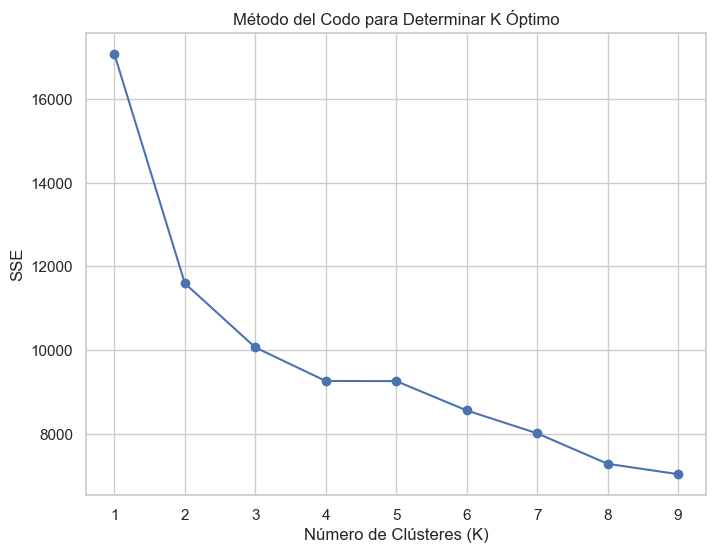

In [6]:
# Calcular la suma de los errores cuadráticos (SSE) para diferentes valores de K
sse = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Número de Clústeres (K)')
plt.ylabel('SSE')
plt.title('Método del Codo para Determinar K Óptimo')
plt.show()

**Observación:** Buscamos el punto donde la disminución del SSE se suaviza. Supongamos que K=4 es adecuado para este dataset.

### 5.2. Aplicar K-Means con K Óptimo

In [8]:
# Aplicar K-Means con K=2
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.labels_

# Añadir las etiquetas de clúster al DataFrame
df_pca['Cluster'] = labels

c:\Users\jgibert\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


## 6. Visualización de los Clústeres <a name="6"></a>

### 6.1. Gráfico de Dispersión de las Componentes Principales

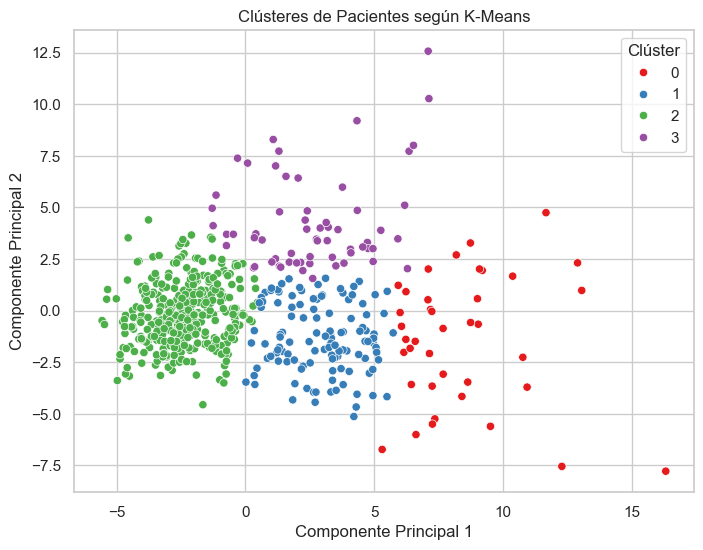

In [9]:
# Graficar los clústeres en el espacio de las componentes principales
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette='Set1')
plt.title('Clústeres de Pacientes según K-Means')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Clúster')
plt.show()

### 6.2. Distribución de Diagnóstico Real en Cada Clúster

diagnosis    0    1
Cluster            
0           39    0
1          117    3
2           22  326
3           34   28


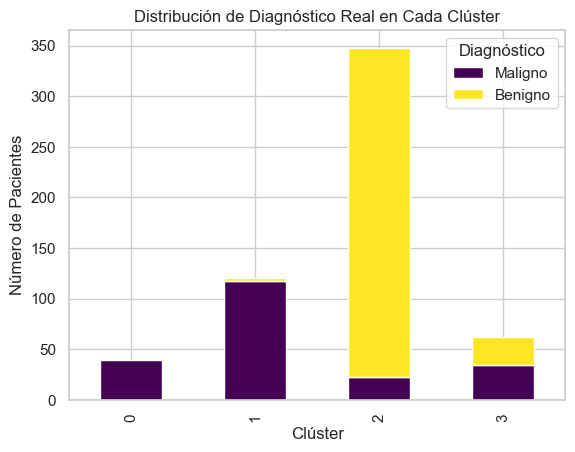

In [10]:
# Tabla de contingencia entre clúster y diagnóstico real
contingency_table = pd.crosstab(df_pca['Cluster'], df_pca['diagnosis'])
print(contingency_table)

# Graficar la distribución
contingency_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Distribución de Diagnóstico Real en Cada Clúster')
plt.xlabel('Clúster')
plt.ylabel('Número de Pacientes')
plt.legend(['Maligno', 'Benigno'], title='Diagnóstico')
plt.show()

## 7. Análisis de Sesgos en los Grupos Formados <a name="7"></a>

Analizaremos si los clústeres formados están asociados con características demográficas o clínicas específicas, lo que podría indicar un sesgo en el agrupamiento.

### 7.1. Asociación entre Clúster y Diagnóstico

Observamos si los clústeres corresponden mayoritariamente a un tipo de diagnóstico.

In [12]:
# Calcular porcentajes
cluster_0 = contingency_table.loc[0] / contingency_table.loc[0].sum() * 100
cluster_1 = contingency_table.loc[1] / contingency_table.loc[1].sum() * 100
cluster_2 = contingency_table.loc[2] / contingency_table.loc[2].sum() * 100
cluster_3 = contingency_table.loc[3] / contingency_table.loc[3].sum() * 100

print("Porcentaje de diagnósticos en Clúster 0:")
print(cluster_0)

print("\nPorcentaje de diagnósticos en Clúster 1:")
print(cluster_1)

print("\nPorcentaje de diagnósticos en Clúster 2:")
print(cluster_2)

print("\nPorcentaje de diagnósticos en Clúster 3:")
print(cluster_3)

Porcentaje de diagnósticos en Clúster 0:
diagnosis
0    100.0
1      0.0
Name: 0, dtype: float64

Porcentaje de diagnósticos en Clúster 1:
diagnosis
0    97.5
1     2.5
Name: 1, dtype: float64

Porcentaje de diagnósticos en Clúster 2:
diagnosis
0     6.321839
1    93.678161
Name: 2, dtype: float64

Porcentaje de diagnósticos en Clúster 3:
diagnosis
0    54.83871
1    45.16129
Name: 3, dtype: float64


**Interpretación:** Si un clúster está compuesto principalmente por pacientes con diagnóstico maligno o benigno, esto indica que el algoritmo ha agrupado a los pacientes según características asociadas al diagnóstico.

### 7.2. Análisis de Variables Clínicas por Clúster

Examinaremos si hay diferencias significativas en las características clínicas entre los clústeres.

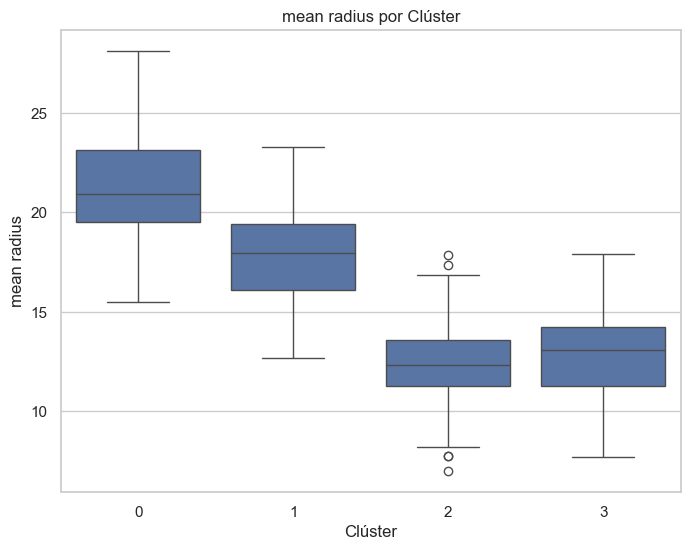

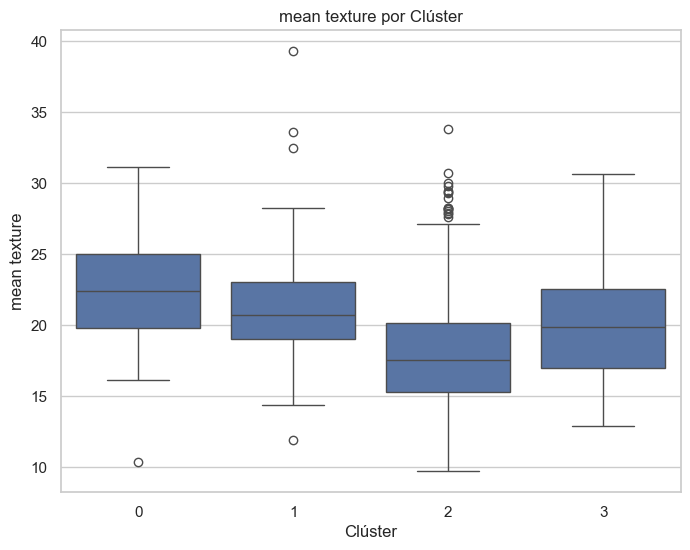

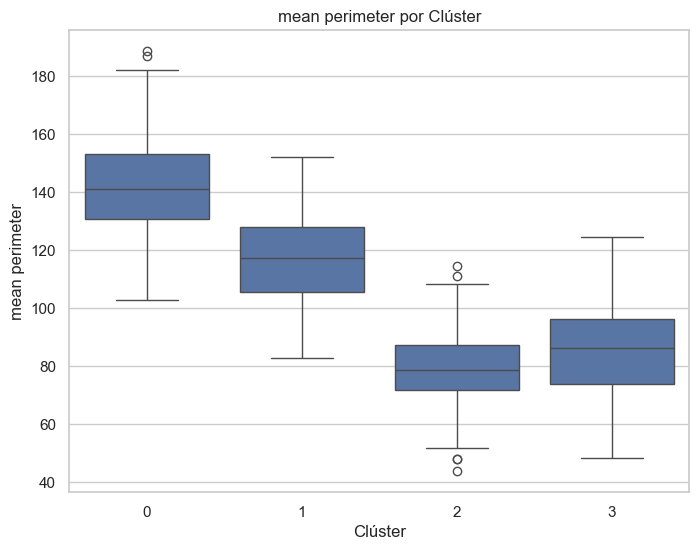

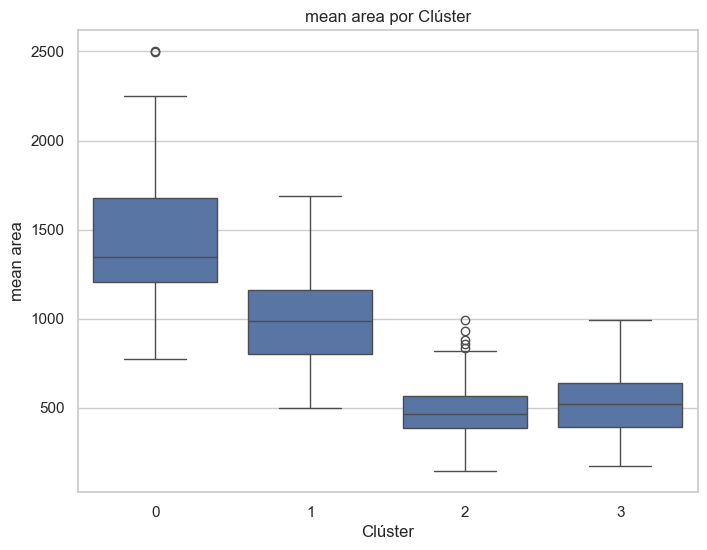

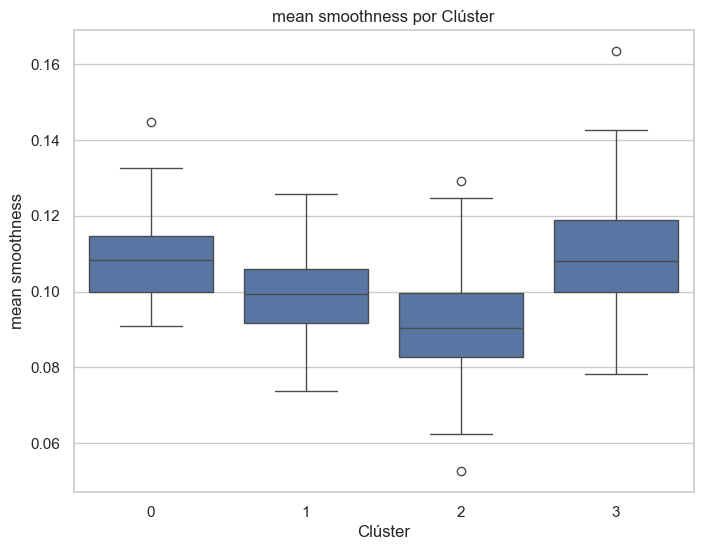

In [13]:
# Añadir etiquetas de clúster al DataFrame original
data['Cluster'] = labels

# Seleccionar algunas características para el análisis
variables = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness']

# Crear boxplots de cada variable por clúster
for var in variables:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Cluster', y=var, data=data)
    plt.title(f'{var} por Clúster')
    plt.xlabel('Clúster')
    plt.ylabel(var)
    plt.show()

**Observación:** Si existen diferencias notables en estas características entre los clústeres, podemos entender mejor cómo el algoritmo ha agrupado a los pacientes.

### 7.3. Consideraciones sobre Sesgos

- **Sesgo de Representación:** Si ciertos grupos (por ejemplo, por edad, género o etnia) están sobrerrepresentados en un clúster, esto podría indicar un sesgo.
- **Impacto Clínico:** Es importante asegurar que el agrupamiento no refuerce desigualdades o conduzca a interpretaciones erróneas en contextos de salud.

## 8. Conclusiones <a name="8"></a>

- **Agrupamiento Significativo:** El algoritmo K-Means ha agrupado a los pacientes en clústeres que parecen corresponderse con el diagnóstico real.
- **Análisis de Sesgos:** Al analizar las características y distribución de diagnósticos en los clústeres, podemos identificar posibles sesgos en cómo el algoritmo agrupa a los pacientes.
- **Importancia en Salud:** Comprender cómo los algoritmos de agrupamiento funcionan y sus posibles sesgos es crucial para su aplicación ética y efectiva en el ámbito clínico.

## 9. Recursos Adicionales <a name="9"></a>

- **Introducción al Análisis de Componentes Principales (PCA):** [Artículo en Wikipedia](https://es.wikipedia.org/wiki/An%C3%A1lisis_de_componentes_principales)